# Análise de Dados CTE 2022-2024

## Introdução

Este notebook realiza uma análise exploratória dos dados de Conhecimento de Transporte Eletrônico (CTE) do período de 2022 a 2024. O objetivo é processar, limpar e visualizar os dados para identificar padrões relacionados a produtos agrícolas como gesso e calcário.

### Principais etapas da análise:

1. **Carregamento e limpeza dos dados**: Importação dos dados e remoção de colunas desnecessárias
2. **Filtros específicos**: Seleção apenas de produtos agrícolas relevantes
3. **Tratamento de dados faltantes**: Preenchimento de valores nulos
4. **Remoção de colunas específicas**: Exclusão de campos como CNPJ e datas
5. **Separação de variáveis**: Classificação em numéricas e categóricas
6. **Codificação de variáveis categóricas**: Aplicação de One-Hot Encoding
7. **Análise estatística**: Cálculo de estatísticas descritivas
8. **Detecção de outliers**: Identificação de valores atípicos
9. **Transformações logarítmicas**: Normalização de distribuições
10. **Visualizações**: Criação de gráficos para análise exploratória

---

## 1. Carregamento e Preparação Inicial dos Dados

A primeira etapa consiste em importar as bibliotecas necessárias e carregar os dados do arquivo CSV. Também é carregado um dicionário que define quais colunas devem ser ignoradas na análise.

In [25]:
# ====================================================
# 1) Importação de bibliotecas
# ====================================================
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ====================================================
# 2) Carregar dados
# ====================================================
train = pd.read_csv("../assets/dados/train.csv")
test = pd.read_csv("../assets/dados/test.csv")

print("Formato train:", train.shape)
print("Formato test:", test.shape)
print("\nProporção de classes (labels):")
print(train["labels"].value_counts(normalize=True))

# ====================================================
# 3) Tratamento de valores ausentes
# ====================================================
train_proc = train.copy()
test_proc = test.copy()

# Colunas de datas (anos): manter -1 para indicar "não existe"
date_cols = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year'
]
train_proc[date_cols] = train_proc[date_cols].fillna(-1)
test_proc[date_cols] = test_proc[date_cols].fillna(-1)

# Colunas numéricas contínuas: imputar com mediana
num_cols_for_impute = [
    'relationships', 'funding_rounds', 'funding_total_usd',
    'milestones', 'avg_participants'
]
num_imputer = SimpleImputer(strategy='median')
train_proc[num_cols_for_impute] = num_imputer.fit_transform(train_proc[num_cols_for_impute])
test_proc[num_cols_for_impute] = num_imputer.transform(test_proc[num_cols_for_impute])

# Flags para NaNs originais
for col in date_cols + ['funding_total_usd']:
    train_proc[col + "_was_missing"] = train[col].isna().astype(int)
    test_proc[col + "_was_missing"] = test[col].isna().astype(int)

# ====================================================
# 4) Encoding categórico
# ====================================================
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_cat = ohe.fit_transform(train_proc[['category_code']])
test_cat = ohe.transform(test_proc[['category_code']])

cat_cols = [f"cat_{c}" for c in ohe.categories_[0]]
train_cat_df = pd.DataFrame(train_cat, columns=cat_cols, index=train_proc.index)
test_cat_df = pd.DataFrame(test_cat, columns=cat_cols, index=test_proc.index)

train_proc = pd.concat([train_proc.drop(columns=['category_code']), train_cat_df], axis=1)
test_proc = pd.concat([test_proc.drop(columns=['category_code']), test_cat_df], axis=1)

# ====================================================
# 5) Funções auxiliares
# ====================================================
def winsorize_series(s, lower=0.01, upper=0.99):
    q_low, q_high = s.quantile([lower, upper])
    return np.clip(s, q_low, q_high)

# ====================================================
# 6) Feature Engineering (combinação dos 2 códigos)
# ====================================================

# --- Razões / proporções ---
train_proc['funding_per_relationship'] = train_proc['funding_total_usd'] / (train_proc['relationships'] + 1)
test_proc['funding_per_relationship'] = test_proc['funding_total_usd'] / (test_proc['relationships'] + 1)

train_proc['funding_per_round'] = train_proc['funding_total_usd'] / (train_proc['funding_rounds'] + 1)
test_proc['funding_per_round'] = test_proc['funding_total_usd'] / (test_proc['funding_rounds'] + 1)

train_proc['participants_per_round'] = train_proc['avg_participants'] / (train_proc['funding_rounds'] + 1)
test_proc['participants_per_round'] = test_proc['avg_participants'] / (test_proc['funding_rounds'] + 1)

# --- Interações ---
train_proc['funding_rounds_x_avg_participants'] = train_proc['funding_rounds'] * train_proc['avg_participants']
test_proc['funding_rounds_x_avg_participants'] = test_proc['funding_rounds'] * test_proc['avg_participants']

# --- Winsorização e discretização ---
train_proc['funding_total_usd_log'] = np.log1p(train_proc['funding_total_usd'])
test_proc['funding_total_usd_log'] = np.log1p(test_proc['funding_total_usd'])

train_proc['funding_total_usd_log_win'] = winsorize_series(train_proc['funding_total_usd_log'])
test_proc['funding_total_usd_log_win'] = winsorize_series(test_proc['funding_total_usd_log'])

train_proc['funding_total_bins'] = pd.qcut(train_proc['funding_total_usd'], q=5, duplicates='drop', labels=False).fillna(-1)
test_proc['funding_total_bins'] = pd.qcut(test_proc['funding_total_usd'], q=5, duplicates='drop', labels=False).fillna(-1)

# --- Contagem de tipos de investimento ---
has_cols = [c for c in train_proc.columns if c.startswith("has_")]
train_proc['num_investments_types'] = train_proc[has_cols].sum(axis=1)
test_proc['num_investments_types'] = test_proc[has_cols].sum(axis=1)

# --- Tempos relativos ---
train_proc['tempo_primeiro_funding'] = train_proc['age_first_funding_year']
test_proc['tempo_primeiro_funding'] = test_proc['age_first_funding_year']

train_proc['tempo_ultimo_funding'] = train_proc['age_last_funding_year'] - train_proc['age_first_funding_year']
test_proc['tempo_ultimo_funding'] = test_proc['age_last_funding_year'] - test_proc['age_first_funding_year']

train_proc['tempo_primeiro_marco'] = train_proc['age_first_milestone_year']
test_proc['tempo_primeiro_marco'] = test_proc['age_first_milestone_year']

# --- Novas features sugeridas ---
train_proc['milestones_per_year'] = train_proc['milestones'] / (train_proc['age_last_milestone_year'] + 1)
test_proc['milestones_per_year'] = test_proc['milestones'] / (test_proc['age_last_milestone_year'] + 1)

train_proc['funding_per_year'] = train_proc['funding_total_usd'] / (train_proc['age_last_funding_year'] + 1)
test_proc['funding_per_year'] = test_proc['funding_total_usd'] / (test_proc['age_last_funding_year'] + 1)

train_proc['funding_per_milestone'] = train_proc['funding_total_usd'] / (train_proc['milestones'] + 1)
test_proc['funding_per_milestone'] = test_proc['funding_total_usd'] / (test_proc['milestones'] + 1)

train_proc['relationships_log'] = np.log1p(train_proc['relationships'])
test_proc['relationships_log'] = np.log1p(test_proc['relationships'])

train_proc['diverse_investment'] = (train_proc['num_investments_types'] >= 3).astype(int)
test_proc['diverse_investment'] = (test_proc['num_investments_types'] >= 3).astype(int)

# Extras
train_proc['milestones_per_round'] = train_proc['milestones'] / (train_proc['funding_rounds'] + 1)
test_proc['milestones_per_round'] = test_proc['milestones'] / (test_proc['funding_rounds'] + 1)

train_proc['funding_growth_rate'] = train_proc['funding_total_usd'] / (train_proc['tempo_ultimo_funding'] + 1)
test_proc['funding_growth_rate'] = test_proc['funding_total_usd'] / (test_proc['tempo_ultimo_funding'] + 1)

train_proc['funding_per_participant'] = train_proc['funding_total_usd'] / (train_proc['avg_participants'] + 1)
test_proc['funding_per_participant'] = test_proc['funding_total_usd'] / (test_proc['avg_participants'] + 1)

train_proc['diverse_investment_x_funding'] = train_proc['diverse_investment'] * train_proc['funding_total_usd_log']
test_proc['diverse_investment_x_funding'] = test_proc['diverse_investment'] * test_proc['funding_total_usd_log']

train_proc['early_funded'] = (train_proc['age_first_funding_year'] < 2).astype(int)
test_proc['early_funded'] = (test_proc['age_first_funding_year'] < 2).astype(int)

train_proc['milestones_per_relationship'] = train_proc['milestones'] / (train_proc['relationships'] + 1)
test_proc['milestones_per_relationship'] = test_proc['milestones'] / (test_proc['relationships'] + 1)

# ====================================================
# 7) Salvar bases finais
# ====================================================



# 7) Salvar bases finais
train_clean_rf = train_proc.copy()
test_clean_rf = test_proc.copy()
print("Bases finais salvas para o modelo Randon Forest")


Formato train: (646, 33)
Formato test: (277, 32)

Proporção de classes (labels):
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64
Bases finais salvas para o modelo Randon Forest


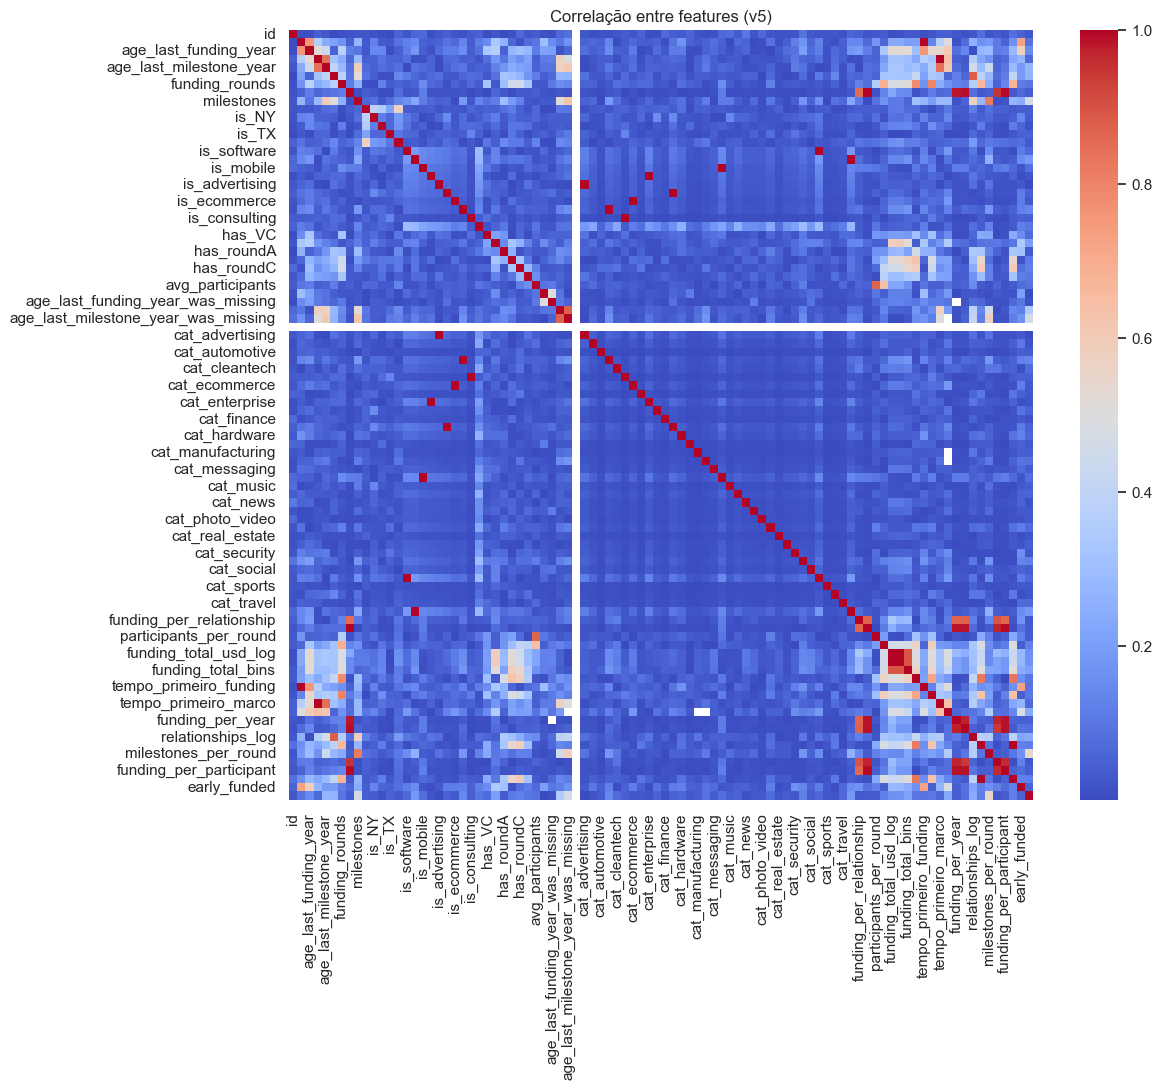

Base usada: (646, 92)
Colunas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'age_first_funding_year_was_missing', 'age_last_funding_year_was_missing', 'age_first_milestone_year_was_missing', 'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing', 'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech', 'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education', 'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video', 'cat_hardware', 'cat_health', 'cat_manufacturing', 'cat_medical', 'cat_messaging', 'c

In [26]:
# Carregar a base v5
df_v5 = train_clean_rf



# Separar X e y
X = df_v5.drop(columns=['labels'])
y = df_v5['labels']

# Análise de correlação
corr_matrix = X.corr().abs()
sns.set(style="white")
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre features (v5)")
plt.show()

print("Base usada:", X.shape)
print("Colunas:", X.columns.tolist())

# Remover features com correlação > 0.95
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

X_filtered = X.drop(columns=to_drop)
X_filtered['labels'] = y  # Adiciona a coluna alvo de volta

print("Features removidas por alta correlação:", to_drop)

# Salvar nova base
train_clean_rf = X_filtered.copy()
print("Base sem colinearidade salva como train_clean_sem_colinearidade.csv")


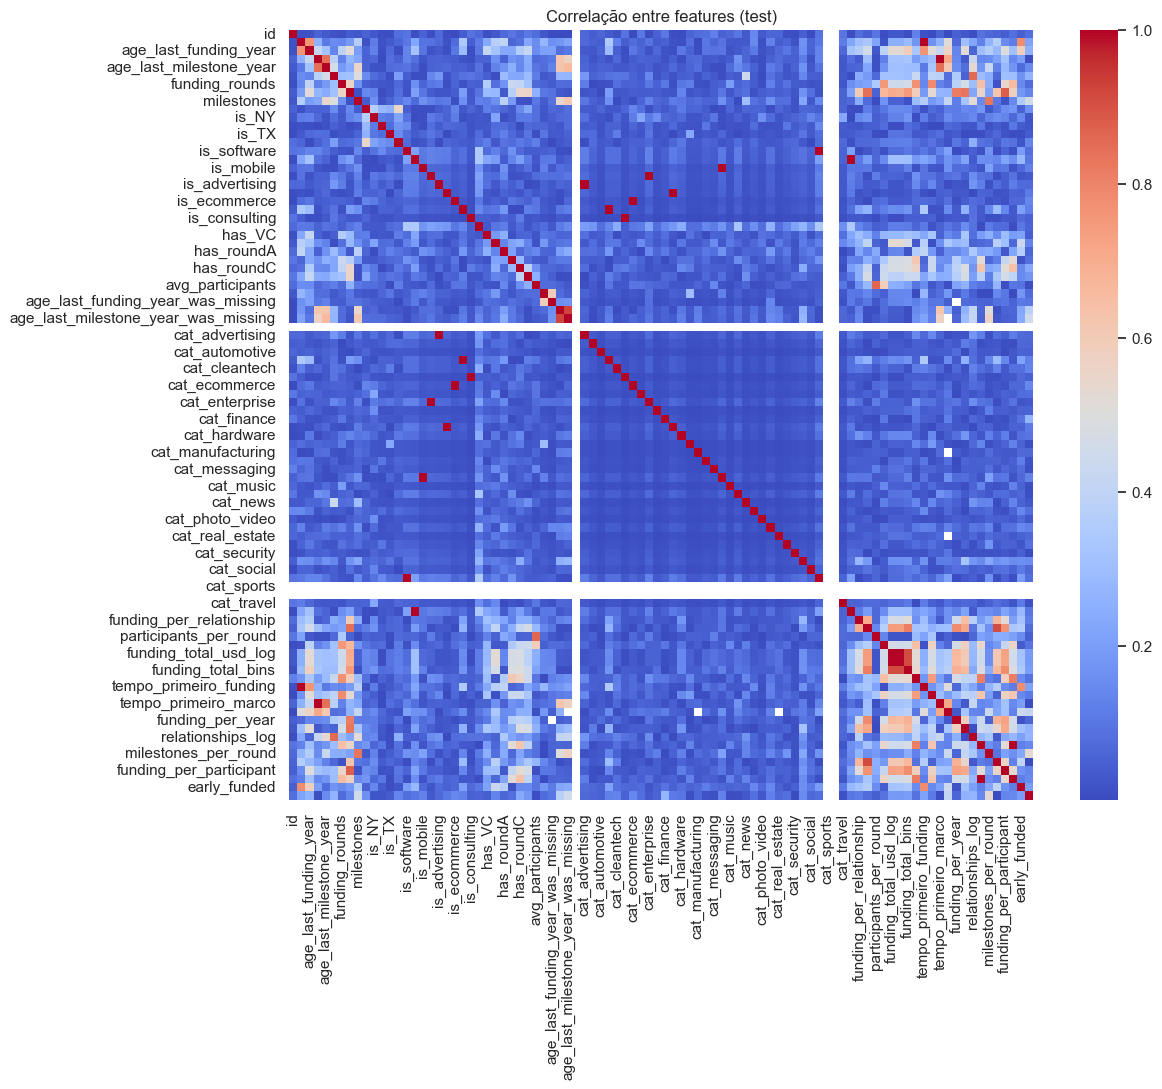

Base usada: (277, 92)
Colunas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'age_first_funding_year_was_missing', 'age_last_funding_year_was_missing', 'age_first_milestone_year_was_missing', 'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing', 'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech', 'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education', 'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video', 'cat_hardware', 'cat_health', 'cat_manufacturing', 'cat_medical', 'cat_messaging', 'c

In [27]:
# Carregar a base tratada com as features
df_v5 = test_clean_rf

# Análise de correlação
corr_matrix = df_v5.corr().abs()
sns.set(style="white")
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre features (test)")
plt.show()

print("Base usada:", df_v5.shape)
print("Colunas:", df_v5.columns.tolist())

# Remover features com correlação > 0.95
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

df_filtered = df_v5.drop(columns=to_drop)

print("Features removidas por alta correlação:", to_drop)

# Salvar nova base
test_clean_rf = df_filtered.copy()

print("Base sem colinearidade salva como test_clean_sem_colinearidade.csv")


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# ==============================
# 1) Definir treino e teste
# ==============================
df = train_clean_rf.copy()
df_test = test_clean_rf.copy()

y_train = df["labels"]
X_train = df.drop(columns=["labels"])

X_test = df_test.drop(columns=["labels"], errors="ignore")  # caso o test não tenha "labels"

# Split treino/validação
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.05,
    random_state=42,
    stratify=y_train
)

# Substituir infinitos por NaN
X_tr = X_tr.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Preencher NaN com 0 (ou outra estratégia, como mediana/média)
X_tr = X_tr.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# ==============================
# 2) Random Forest GridSearch
# ==============================
param_grid_rf = {
    "n_estimators": [300],
    "max_depth": [10],
    "min_samples_split": [10],
    "min_samples_leaf": [1]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

grid_rf = GridSearchCV(
    rf, param_grid_rf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)
grid_rf.fit(X_tr, y_tr)

best_rf = grid_rf.best_estimator_


print("\n[Random Forest]")
print("Melhores parâmetros:", grid_rf.best_params_)

# Avaliação
y_val_pred = best_rf.predict(X_val)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]
print("Val Accuracy:", round(accuracy_score(y_val, y_val_pred), 4))
print("Val ROC-AUC:", round(roc_auc_score(y_val, y_val_proba), 4))
print("Matriz de Confusão (val):\n", confusion_matrix(y_val, y_val_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Random Forest]
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Val Accuracy: 0.8182
Val ROC-AUC: 0.869
Matriz de Confusão (val):
 [[ 8  4]
 [ 2 19]]


Formato train: (646, 33)
Formato test: (277, 32)

Proporção de classes (labels):
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64

Valores ausentes no treino:
age_first_milestone_year    138
age_last_milestone_year     111
age_first_funding_year       35
age_last_funding_year         9
id                            0
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
dtype: int64

Resumo estatístico das numéricas:
                          count          mean           std      min  \
id                        646.0  4.615774e+02  2.648595e+02      1.0   
age_first_funding_year    611.0  2.341718e+00  2.468275e+00      0.0   
age_last_funding_year     637.0  4.037724e+00  2.950923e+00      0.0   
age_first_milestone_year  508.0  3.352657e+00  2.866952e+00      0.0   
age_last_milestone_year   535.0  4.944729e+00  3.213319e+00      0.0   
relationships         

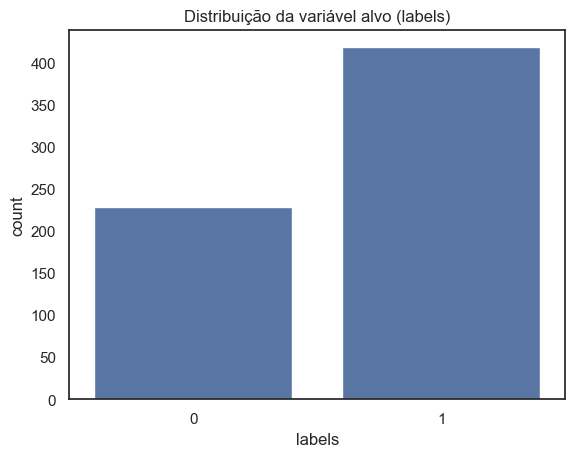

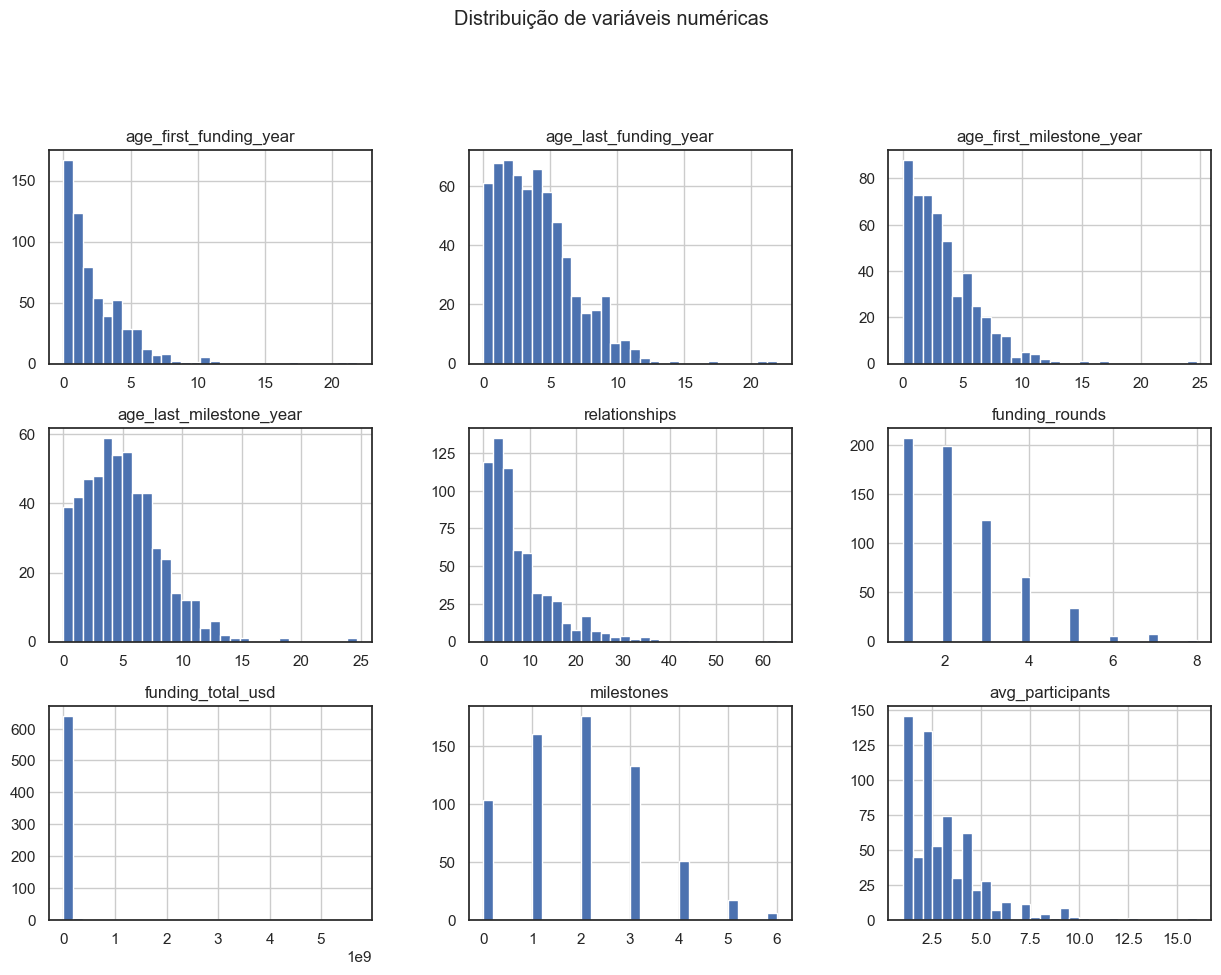

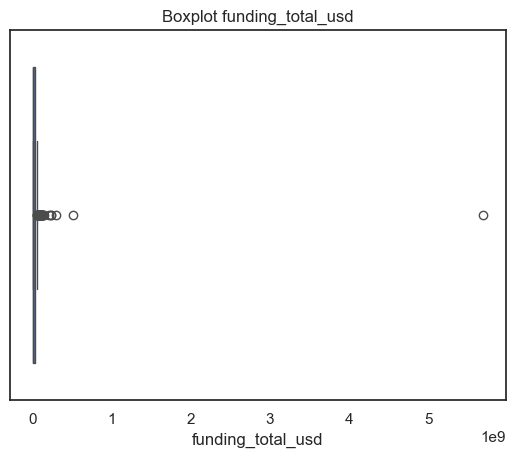

In [29]:
# 1) Importação de bibliotecas
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# 2) Carregar dados
train = pd.read_csv("../assets/dados/train.csv")
test = pd.read_csv("../assets/dados/test.csv")

print("Formato train:", train.shape)
print("Formato test:", test.shape)
print("\nProporção de classes (labels):")
print(train["labels"].value_counts(normalize=True))


# 3) EDA inicial
print("\nValores ausentes no treino:")
print(train.isna().sum().sort_values(ascending=False).head(10))

print("\nResumo estatístico das numéricas:")
print(train.describe().T)

# Distribuição da variável alvo
sns.countplot(x="labels", data=train)
plt.title("Distribuição da variável alvo (labels)")
plt.show()

# Histograma de variáveis numéricas
numeric_cols = [
    'age_first_funding_year','age_last_funding_year',
    'age_first_milestone_year','age_last_milestone_year',
    'relationships','funding_rounds','funding_total_usd',
    'milestones','avg_participants'
]

train[numeric_cols].hist(bins=30, figsize=(15,10))
plt.suptitle("Distribuição de variáveis numéricas", y=1.02)
plt.show()

# Boxplot funding_total_usd
sns.boxplot(x=train['funding_total_usd'])
plt.title("Boxplot funding_total_usd")
plt.show()


# 4) Tratamento de valores ausentes (híbrido)
train_proc = train.copy()
test_proc = test.copy()

# Colunas de datas (anos): manter -1 para indicar "não existe"
date_cols = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year'
]
train_proc[date_cols] = train_proc[date_cols].fillna(-1)
test_proc[date_cols] = test_proc[date_cols].fillna(-1)

# Colunas numéricas contínuas: imputar com mediana
num_cols_for_impute = [
    'relationships', 'funding_rounds', 'funding_total_usd',
    'milestones', 'avg_participants'
]
num_imputer = SimpleImputer(strategy='median')
train_proc[num_cols_for_impute] = num_imputer.fit_transform(train_proc[num_cols_for_impute])
test_proc[num_cols_for_impute] = num_imputer.transform(test_proc[num_cols_for_impute])

# Flags para marcar os NaNs originais (tanto datas quanto funding)
for col in date_cols + ['funding_total_usd']:
    train_proc[col + "_was_missing"] = train[col].isna().astype(int)
    test_proc[col + "_was_missing"] = test[col].isna().astype(int)


# 5) Encoding da variável categórica
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_cat = ohe.fit_transform(train_proc[['category_code']])
test_cat = ohe.transform(test_proc[['category_code']])

cat_cols = [f"cat_{c}" for c in ohe.categories_[0]]
train_cat_df = pd.DataFrame(train_cat, columns=cat_cols, index=train_proc.index)
test_cat_df = pd.DataFrame(test_cat, columns=cat_cols, index=test_proc.index)

train_proc = pd.concat([train_proc.drop(columns=['category_code']), train_cat_df], axis=1)
test_proc = pd.concat([test_proc.drop(columns=['category_code']), test_cat_df], axis=1)


# 6) Feature engineering


# Razões e proporções
train_proc['funding_per_relationship'] = train_proc['funding_total_usd'] / (train_proc['relationships'] + 1)
test_proc['funding_per_relationship'] = test_proc['funding_total_usd'] / (test_proc['relationships'] + 1)

train_proc['funding_per_round'] = train_proc['funding_total_usd'] / (train_proc['funding_rounds'] + 1)
test_proc['funding_per_round'] = test_proc['funding_total_usd'] / (test_proc['funding_rounds'] + 1)

train_proc['participants_per_round'] = train_proc['avg_participants'] / (train_proc['funding_rounds'] + 1)
test_proc['participants_per_round'] = test_proc['avg_participants'] / (test_proc['funding_rounds'] + 1)

# Interações
train_proc['funding_rounds_x_avg_participants'] = train_proc['funding_rounds'] * train_proc['avg_participants']
test_proc['funding_rounds_x_avg_participants'] = test_proc['funding_rounds'] * test_proc['avg_participants']

# Winsorização e discretização
def winsorize_series(s, lower=0.01, upper=0.99):
    q_low, q_high = s.quantile([lower, upper])
    return np.clip(s, q_low, q_high)

train_proc['funding_total_usd_log'] = np.log1p(train_proc['funding_total_usd'])
test_proc['funding_total_usd_log'] = np.log1p(test_proc['funding_total_usd'])

train_proc['funding_total_usd_log_win'] = winsorize_series(train_proc['funding_total_usd_log'])
test_proc['funding_total_usd_log_win'] = winsorize_series(test_proc['funding_total_usd_log'])

train_proc['funding_total_bins'] = pd.qcut(train_proc['funding_total_usd'], q=5, duplicates='drop', labels=False)
test_proc['funding_total_bins'] = pd.qcut(test_proc['funding_total_usd'], q=5, duplicates='drop', labels=False)

train_proc['funding_total_bins'] = train_proc['funding_total_bins'].fillna(-1)
test_proc['funding_total_bins'] = test_proc['funding_total_bins'].fillna(-1)

# Contagem de tipos de investimento
has_cols = [c for c in train_proc.columns if c.startswith("has_")]
train_proc['num_investments_types'] = train_proc[has_cols].sum(axis=1)
test_proc['num_investments_types'] = test_proc[has_cols].sum(axis=1)

# Tempos relativos
train_proc['tempo_primeiro_funding'] = train_proc['age_first_funding_year']
test_proc['tempo_primeiro_funding'] = test_proc['age_first_funding_year']

train_proc['tempo_ultimo_funding'] = train_proc['age_last_funding_year'] - train_proc['age_first_funding_year']
test_proc['tempo_ultimo_funding'] = test_proc['age_last_funding_year'] - test_proc['age_first_funding_year']

train_proc['tempo_primeiro_marco'] = train_proc['age_first_milestone_year']
test_proc['tempo_primeiro_marco'] = test_proc['age_first_milestone_year']

# Novas features sugeridas
train_proc['milestones_per_year'] = train_proc['milestones'] / (train_proc['age_last_milestone_year'] + 1)
test_proc['milestones_per_year'] = test_proc['milestones'] / (test_proc['age_last_milestone_year'] + 1)

train_proc['funding_per_year'] = train_proc['funding_total_usd'] / (train_proc['age_last_funding_year'] + 1)
test_proc['funding_per_year'] = test_proc['funding_total_usd'] / (test_proc['age_last_funding_year'] + 1)

train_proc['funding_per_milestone'] = train_proc['funding_total_usd'] / (train_proc['milestones'] + 1)
test_proc['funding_per_milestone'] = test_proc['funding_total_usd'] / (test_proc['milestones'] + 1)

train_proc['relationships_log'] = np.log1p(train_proc['relationships'])
test_proc['relationships_log'] = np.log1p(test_proc['relationships'])

train_proc['diverse_investment'] = (train_proc['num_investments_types'] >= 3).astype(int)
test_proc['diverse_investment'] = (test_proc['num_investments_types'] >= 3).astype(int)



# 6.1) Novas features sugeridas


# 1) Razão milestones / funding rounds
train_proc['milestones_per_round'] = train_proc['milestones'] / (train_proc['funding_rounds'] + 1)
test_proc['milestones_per_round'] = test_proc['milestones'] / (test_proc['funding_rounds'] + 1)

# 2) Taxa de crescimento de funding
train_proc['funding_growth_rate'] = train_proc['funding_total_usd'] / (train_proc['tempo_ultimo_funding'] + 1)
test_proc['funding_growth_rate'] = test_proc['funding_total_usd'] / (test_proc['tempo_ultimo_funding'] + 1)

# 3) Proporção de funding por participante
train_proc['funding_per_participant'] = train_proc['funding_total_usd'] / (train_proc['avg_participants'] + 1)
test_proc['funding_per_participant'] = test_proc['funding_total_usd'] / (test_proc['avg_participants'] + 1)

# 4) Interação diversidade x funding
train_proc['diverse_investment_x_funding'] = train_proc['diverse_investment'] * train_proc['funding_total_usd_log']
test_proc['diverse_investment_x_funding'] = test_proc['diverse_investment'] * test_proc['funding_total_usd_log']

# 5) Dummy para early funding (primeiro funding nos 2 primeiros anos)
train_proc['early_funded'] = (train_proc['age_first_funding_year'] < 2).astype(int)
test_proc['early_funded'] = (test_proc['age_first_funding_year'] < 2).astype(int)

# 6) Razão milestones / relationships
train_proc['milestones_per_relationship'] = train_proc['milestones'] / (train_proc['relationships'] + 1)
test_proc['milestones_per_relationship'] = test_proc['milestones'] / (test_proc['relationships'] + 1)


# Criar features derivadas
train_proc["funding_per_year"] = train_proc["funding_total_usd"] / (train_proc["age_last_funding_year"] + 1e-6)
train_proc["funding_per_round"] = train_proc["funding_total_usd"] / (train_proc["funding_rounds"].replace(0, np.nan))
train_proc["funding_per_milestone"] = train_proc["funding_total_usd"] / (train_proc["milestones"].replace(0, np.nan))
train_proc["funding_per_participant"] = train_proc["funding_total_usd"] / (train_proc["avg_participants"].replace(0, np.nan))

# Preencher NaN só nas features derivadas
for col in ["funding_per_year", "funding_per_round", "funding_per_milestone", "funding_per_participant"]:
    train_proc[col] = train_proc[col].fillna(0)

# 7) Salvar bases finais
train_clean_v1 = train_proc.copy()
test_clean_v1 = test_proc.copy()


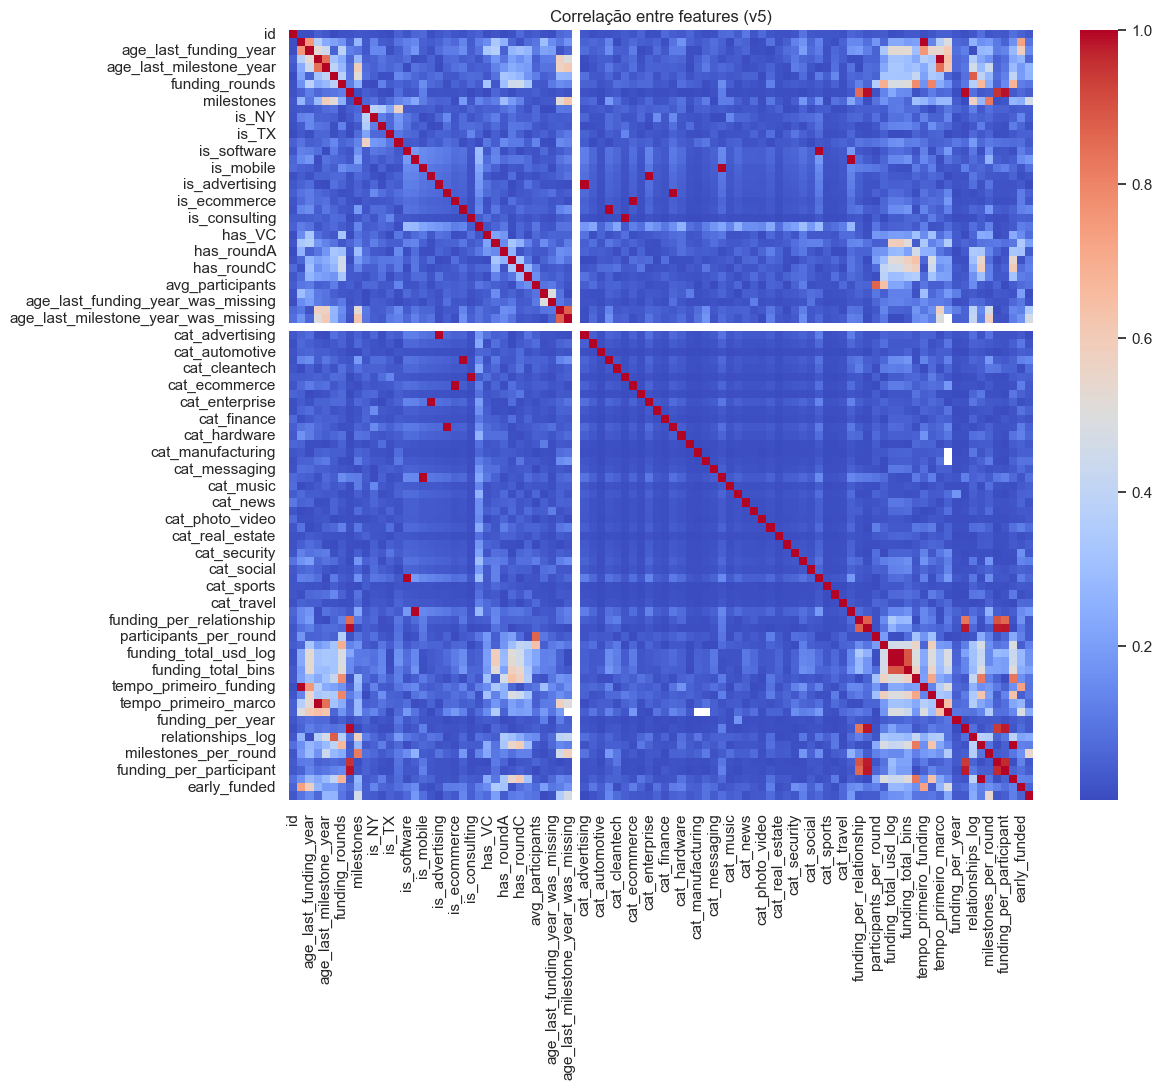

Base usada: (646, 92)
Colunas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'age_first_funding_year_was_missing', 'age_last_funding_year_was_missing', 'age_first_milestone_year_was_missing', 'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing', 'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech', 'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education', 'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video', 'cat_hardware', 'cat_health', 'cat_manufacturing', 'cat_medical', 'cat_messaging', 'c

In [30]:
# Carregar a base v5
df_v5 = train_clean_v1



# Separar X e y
X = df_v5.drop(columns=['labels'])
y = df_v5['labels']

# Análise de correlação
corr_matrix = X.corr().abs()
sns.set(style="white")
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre features (v5)")
plt.show()

print("Base usada:", X.shape)
print("Colunas:", X.columns.tolist())

# Remover features com correlação > 0.95
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

X_filtered = X.drop(columns=to_drop)
X_filtered['labels'] = y  # Adiciona a coluna alvo de volta

print("Features removidas por alta correlação:", to_drop)

# Salvar nova base
train_clean_sem_colinearidade = X_filtered.copy()
print("Base sem colinearidade salva como train_clean_sem_colinearidade.csv")


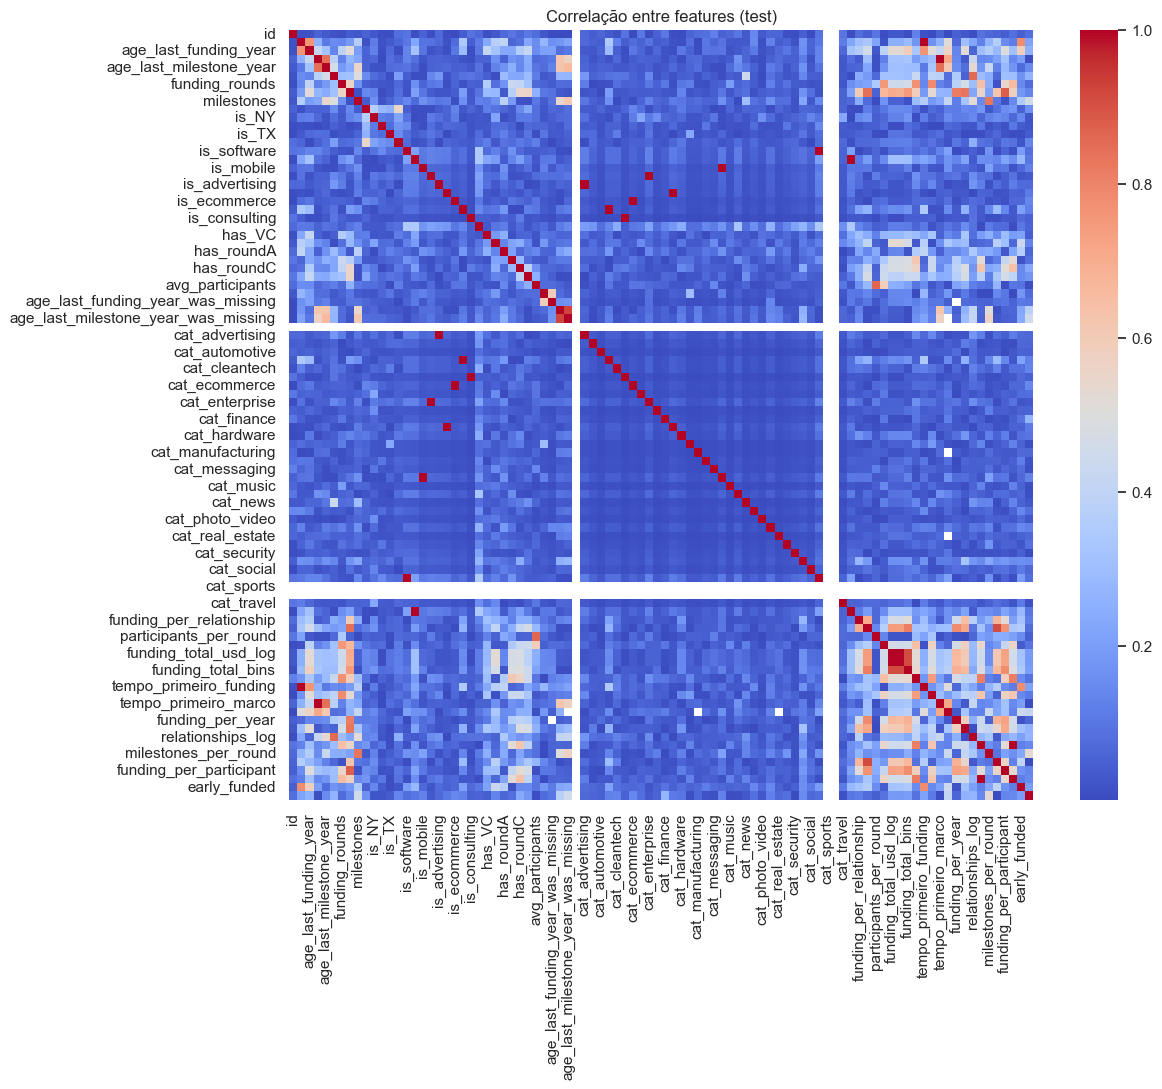

Base usada: (277, 92)
Colunas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'age_first_funding_year_was_missing', 'age_last_funding_year_was_missing', 'age_first_milestone_year_was_missing', 'age_last_milestone_year_was_missing', 'funding_total_usd_was_missing', 'cat_advertising', 'cat_analytics', 'cat_automotive', 'cat_biotech', 'cat_cleantech', 'cat_consulting', 'cat_ecommerce', 'cat_education', 'cat_enterprise', 'cat_fashion', 'cat_finance', 'cat_games_video', 'cat_hardware', 'cat_health', 'cat_manufacturing', 'cat_medical', 'cat_messaging', 'c

In [31]:
# Carregar a base tratada com as features
df_v5 = test_clean_v1

# Análise de correlação
corr_matrix = df_v5.corr().abs()
sns.set(style="white")
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre features (test)")
plt.show()

print("Base usada:", df_v5.shape)
print("Colunas:", df_v5.columns.tolist())

# Remover features com correlação > 0.95
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

df_filtered = df_v5.drop(columns=to_drop)

print("Features removidas por alta correlação:", to_drop)

# Salvar nova base
test_clean_sem_colinearidade = df_filtered.copy()

print("Base sem colinearidade salva como test_clean_sem_colinearidade.csv")


In [32]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import numpy as np
import pandas as pd

# Carregar base sem colinearidade
train_clean = train_clean_sem_colinearidade
train_clean = train_clean.drop(columns=["id"])

test_clean = test_clean_sem_colinearidade


X = train_clean.drop(columns=['labels'])
y = train_clean['labels']

# Garantir que não existam inf ou NaN
X = X.replace([np.inf, -np.inf], np.nan)  # troca inf por NaN
X = X.fillna(0)  # preenche NaN com 0

# Garantir que não existam inf ou NaN no teste
test_clean = test_clean.replace([np.inf, -np.inf], np.nan)
test_clean = test_clean.fillna(0)


# Cross-validation com 15 folds
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)


# 2) Gradient Boosting GridSearch

param_grid_gb = {
    'n_estimators': [500],
    'max_depth': [3],
    'learning_rate': [0.01]
}

gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=cv, scoring="accuracy", n_jobs=-1)
grid_gb.fit(X, y)

print("\n[Random Forest]")
print("Melhores parâmetros:", grid_rf.best_params_)

# Avaliação
y_val_pred = best_rf.predict(X_val)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]
print("Val Accuracy:", round(accuracy_score(y_val, y_val_pred), 4))
print("Val ROC-AUC:", round(roc_auc_score(y_val, y_val_proba), 4))
print("Matriz de Confusão (val):\n", confusion_matrix(y_val, y_val_pred))



print("\nMelhor GradientBoosting:")
print("Parâmetros:", grid_gb.best_params_)
print("Accuracy média:", grid_gb.best_score_)

best_gb = grid_gb.best_estimator_



# 4) Ensemble (VotingClassifier)
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_

ensemble = VotingClassifier(
    estimators=[("rf", best_rf), ("gb", best_gb)],
    voting="soft",
    n_jobs=-1
)

grid_ens = GridSearchCV(ensemble, {}, cv=cv, scoring="accuracy", n_jobs=-1)
grid_ens.fit(X, y)

print("\nMelhor Ensemble (RF + GB):")
print("Accuracy média:", grid_ens.best_score_)

final_model = grid_ens.best_estimator_


# 5) Preparar teste e submissão

train_cols = set(train_clean.drop(columns=["labels"]).columns)
test_cols = set(test_clean.drop(columns=["id"]).columns)

print("\nColunas só no treino:", train_cols - test_cols)
print("Colunas só no teste:", test_cols - train_cols)

# Alinha as colunas do teste com as do treino
train_features = final_model.feature_names_in_
test_clean_aligned = test_clean[["id"] + list(train_features)]

# Faz as previsões
preds = final_model.predict(test_clean_aligned.drop(columns=["id"]))

# Criar submissão
submission = pd.DataFrame({
    "id": test_clean["id"],
    "labels": preds
})
submission.to_csv("submission_ensemble.csv", index=False)

print("\n Arquivo submission_ensemble.csv salvo com sucesso!")
print(submission.head())

c:\Users\Inteli\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



[Random Forest]
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Val Accuracy: 0.8182
Val ROC-AUC: 0.869
Matriz de Confusão (val):
 [[ 8  4]
 [ 2 19]]

Melhor GradientBoosting:
Parâmetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Accuracy média: 0.7972163495419309

Melhor Ensemble (RF + GB):
Accuracy média: 0.8003171247357292

Colunas só no treino: set()
Colunas só no teste: {'funding_per_participant', 'funding_per_round', 'funding_growth_rate', 'funding_per_milestone'}

 Arquivo submission_ensemble.csv salvo com sucesso!
    id  labels
0   70       1
1   23       0
2  389       1
3  872       1
4  920       0


In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Carregar base tratada
train_clean = pd.read_csv("train_clean_v5.csv")
X = train_clean.drop(columns=['id','labels'])
y = train_clean['labels']

# Modelo
rf = RandomForestClassifier(
    n_estimators=300, max_depth=10, min_samples_leaf=1, min_samples_split=2,
    random_state=42, n_jobs=-1, class_weight="balanced"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for cutoff in [0.4, 0.45, 0.5, 0.55, 0.6]:
    accs = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        rf.fit(X_train, y_train)
        probs = rf.predict_proba(X_val)[:,1]  # probabilidade de classe 1
        preds = (probs >= cutoff).astype(int) # aplica cutoff customizado
        accs.append(accuracy_score(y_val, preds))

    print(f"Cutoff={cutoff} -> Accuracy média: {np.mean(accs):.4f}")


Cutoff=0.4 -> Accuracy média: 0.7709
Cutoff=0.45 -> Accuracy média: 0.7802
Cutoff=0.5 -> Accuracy média: 0.7925
Cutoff=0.55 -> Accuracy média: 0.7771
Cutoff=0.6 -> Accuracy média: 0.7678
